# <font color='#31708f'><center>Preprocessing<a class="anchor" id="second-bullet"></a></center></font>

In [ ]:
pwd   #Display the path of current directory

In [ ]:
import glob

#Make sure glob.glob returns a list of files. List all json files in newman folder, sorted in ascending order.
file_list = sorted(glob.glob('/home/smsta/Desktop/zendesk_tag_cloud/newman_lockdown/*.json'))
for filename in file_list:
    print(filename)

In [ ]:
import ijson
def parse_json(json_filename):
        with open(filename, 'r', encoding="utf8") as file:
            # load json iteratively
            parser = ijson.parse(file)
            for prefix, event, value in parser:
                print('prefix={}, event={}, value={}'.format(prefix, event, value))
    
if __name__ == '__main__':
    parse_json(filename)

In [ ]:
import ijson
import re
from string import punctuation
def extract_ticket_text_generator(json_filename):
    """This function takes a list of files with tickets and extracts text from each ticket. The result is a list of text strings."""
    for filename in file_list:
            with open(filename, 'r', encoding="utf8") as input_file:
                # Extract specific items from the file
                tickets = ijson.items(input_file, 'run.executions.item.assertions.item.assertion')
                for ticket in tickets:
                    # Extract the substring between two markers
                    l = re.findall('plain_body(.+?)public', ticket)
                    #Remove escaped newline '\\n' and non-breaking space 'nbsp' characters
                    m = [re.sub(r'\\n|nbsp', ' ', t) for t in l]
                    # Remove any URL within a string
                    p = [re.sub(r'http\S+|www\S+', '', o) for o in m]          
                    # Remove all of the punctuation in any item in the list. The result is for each ticket a list of comments.
                    q = [''.join(c for c in s if c not in punctuation) for s in p]
                    # Join list elements without any separator. The result is for each ticket a list of merged comments.
                    r = [' '.join(q)] 
                    yield(r)
                
    if __name__ == '__main__':
        extract_ticket_text_generator(filename)

In [ ]:
def create_txt_files():
        """This function takes a list of text strings and saves each ticket in a .txt file."""
        data = extract_ticket_text_generator(filename)
        # Make a flat list out of list of lists.
        flat_list = [item for sublist in data for item in sublist]
        for i in range(len(flat_list)):
            with open("ticket_%d.txt" % (i+59047), 'w', encoding="utf-8") as f:
                f.write(flat_list[i])

In [ ]:
create_txt_files()

In zendesk_tag_cloud create folder zendesk_txt_lockdown and move all .txt files generated from create_txt_files() function into it. 

# <font color='#31708f'><center>Unigram WordCloud<a class="anchor" id="third-bullet"></a></center></font>

In [8]:
pwd

'/home/smsta/Desktop/zendesk_tag_cloud'

In [9]:
cd Desktop/zendesk_tag_cloud

[Errno 2] No such file or directory: 'Desktop/zendesk_tag_cloud'
/home/smsta/Desktop/zendesk_tag_cloud


In [10]:
from pathlib import Path

all_txt_files =[]
#control order of results from iterator
for file in sorted(Path("zendesk_txt_lockdown").iterdir()):
    all_txt_files.append(file.name)
print(all_txt_files[:6])
    # counts the length of the list
len(all_txt_files)

['ticket_59047.txt', 'ticket_59048.txt', 'ticket_59049.txt', 'ticket_59050.txt', 'ticket_59051.txt', 'ticket_59052.txt']


939

In [11]:
import natsort 

#sort filenames in directory ascending
all_txt_files_sorted = natsort.natsorted(all_txt_files)
all_txt_files_sorted[:6]

['ticket_59047.txt',
 'ticket_59048.txt',
 'ticket_59049.txt',
 'ticket_59050.txt',
 'ticket_59051.txt',
 'ticket_59052.txt']

In [12]:
cd zendesk_txt_lockdown

/home/smsta/Desktop/zendesk_tag_cloud/zendesk_txt_lockdown


In [13]:
all_docs = []
for txt_file in all_txt_files_sorted:
    with open(txt_file, encoding="utf-8") as f:
        txt_file_as_string = f.read()
        all_docs.append(txt_file_as_string)
all_docs[:6]

['Is it possible to set up in a single event different bookable items which are charged in different currencies This ticket has been assigned by Round Robin Hi Claire   Thank you for your inquiry Here are the steps outlined on how to activate multiple currency selection  1 Go to Setup gt Finance gt Settings  2 Select Allow currency selection 3 Click Save  As a result on the basket page delegates will be able to select a different currency to pay with   Please let us know if it worked for you or any questions arise   Kind Regards  Svetlana     Svetlana Staneva  Technical Support Specialist  Eventsforce Solutions Ltd   \u200bUK Support 44 020 3868 5338  US Support 1 2132694914  APAC Support 61 7 3177 7234  Web  Hi Claire   Further to my previous email you can create a different general price for each bookable item in Setup gt Finance gt Prices When setting up the general price there is a dropdown for currency from which you can select the preferred currency   Set up price for bookable it

# <font color='#576675'>Load the packages:</font>

In [ ]:




import re

import numpy as np



# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn

%matplotlib inline

In [ ]:
#from sklearn.feature_extraction.text import pandas as pd

# <font color='#576675'>Tokenize and Clean-up using gensim’s simple_preprocess()</font>

In [14]:
import gensim

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(all_docs))

print(data_words[:2])

[['is', 'it', 'possible', 'to', 'set', 'up', 'in', 'single', 'event', 'different', 'bookable', 'items', 'which', 'are', 'charged', 'in', 'different', 'currencies', 'this', 'ticket', 'has', 'been', 'assigned', 'by', 'round', 'robin', 'hi', 'claire', 'thank', 'you', 'for', 'your', 'inquiry', 'here', 'are', 'the', 'steps', 'outlined', 'on', 'how', 'to', 'activate', 'multiple', 'currency', 'selection', 'go', 'to', 'setup', 'gt', 'finance', 'gt', 'settings', 'select', 'allow', 'currency', 'selection', 'click', 'save', 'as', 'result', 'on', 'the', 'basket', 'page', 'delegates', 'will', 'be', 'able', 'to', 'select', 'different', 'currency', 'to', 'pay', 'with', 'please', 'let', 'us', 'know', 'if', 'it', 'worked', 'for', 'you', 'or', 'any', 'questions', 'arise', 'kind', 'regards', 'svetlana', 'svetlana', 'staneva', 'technical', 'support', 'specialist', 'eventsforce', 'solutions', 'ltd', 'uk', 'support', 'us', 'support', 'apac', 'support', 'web', 'hi', 'claire', 'further', 'to', 'my', 'previous

# <font color='#576675'>Lemmatization</font>

In [15]:
import spacy

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])

['possible set single event different bookable item charge different currency ticket assign thank inquiry here step outline how activate multiple currency selection go setup finance setting select allow currency selection click save result basket page delegate will able select different currency pay let know work question arise kind regard svetlana support support support web far previous email can create different general price bookable item setup finance price when set general price dropdown currency can select preferred currency set price bookable item go setup finance price click add add price price descriptor name enter name price apply select general price add new price enter amount currency dropdown select preferred currency date enter when start line item description enter line how should appear basket checkout page click save bookable item general price link price bookable item would recommend make test registration see action basket page let know work question arise kind rega

In [ ]:
from wordcloud import STOPWORDS 

#Create custom list of English stopwords
custom_stopwords = list(STOPWORDS)+["a","about","above","after","again","against","ain","all","am","an","and","any","are","aren","aren't","as","at","be","because","been","before","being","below","between","both","but","by","can","couldn","couldn't","d","did","didn","didn't","do","does","doesn","doesn't","doing","don","don't","down","during","each","few","for","from","further","had","hadn","hadn't","has","hasn","hasn't","have","haven","haven't","having","he","her","here","hers","herself","him","himself","his","how","i","if","in","into","is","isn","isn't","it","it's","its","itself","just","ll","m","ma","me","mightn","mightn't","more","most","mustn","mustn't","my","myself","needn","needn't","no","nor","not","now","o","of","off","on","once","only","or","other","our","ours","ourselves","out","over","own","re","s","same","shan","shan't","she","she's","should","should've","shouldn","shouldn't","so","some","such","t","than","that","that'll","the","their","theirs","them","themselves","then","there","these","they","this","those","through","to","too","under","until","up","ve","very","was","wasn","wasn't","we","were","weren","weren't","what","when","where","which","while","who","whom","why","will","with","won","won't","wouldn","wouldn't","y","you","you'd","you'll","you're","you've","your","yours","yourself","yourselves","could","he'd","he'll","he's","here's","how's","i'd","i'll","i'm","i've","let's","ought","she'd","she'll","that's","there's","they'd","they'll","they're","they've","we'd","we'll","we're","we've","what's","when's","where's","who's","why's","would","able","abst","accordance","according","accordingly","across","act","actually","added","adj","affected","affecting","affects","afterwards","ah","almost","alone","along","already","also","although","always","among","amongst","announce","another","anybody","anyhow","anymore","anyone","anything","anyway","anyways","anywhere","apparently","approximately","arent","arise","around","aside","ask","asking","auth","available","away","awfully","b","back","became","become","becomes","becoming","beforehand","begin","beginning","beginnings","begins","behind","believe","beside","besides","beyond","biol","brief","briefly","c","ca","came","cannot","can't","cause","causes","certain","certainly","co","com","come","comes","contain","containing","contains","couldnt","date","different","done","downwards","due","e","ed","edu","effect","eg","eight","eighty","either","else","elsewhere","end","ending","enough","especially","et","etc","even","ever","every","everybody","everyone","everything","everywhere","ex","except","f","far","ff","fifth","first","five","fix","followed","following","follows","former","formerly","forth","found","four","furthermore","g","gave","get","gets","getting","give","given","gives","giving","go","goes","gone","got","gotten","h","happens","hardly","hed","hence","hereafter","hereby","herein","heres","hereupon","hes","hi","hid","hither","home","howbeit","however","hundred","id","ie","im","immediate","immediately","importance","important","inc","indeed","index","information","instead","invention","inward","itd","it'll","j","k","keep","keeps","kept","kg","km","know","known","knows","l","largely","last","lately","later","latter","latterly","least","less","lest","let","lets","like","liked","likely","line","little","'ll","look","looking","looks","ltd","made","mainly","make","makes","many","may","maybe","mean","means","meantime","meanwhile","merely","mg","might","million","miss","ml","moreover","mostly","mr","mrs","much","mug","must","n","na","name","namely","nay","nd","near","nearly","necessarily","necessary","need","needs","neither","never","nevertheless","new","next","nine","ninety","nobody","non","none","nonetheless","noone","normally","nos","noted","nothing","nowhere","obtain","obtained","obviously","often","oh","ok","okay","old","omitted","one","ones","onto","ord","others","otherwise","outside","overall","owing","p","page","pages","part","particular","particularly","past","per","perhaps","placed","please","plus","poorly","possible","possibly","potentially","pp","predominantly","present","previously","primarily","probably","promptly","proud","provides","put","q","que","quickly","quite","qv","r","ran","rather","rd","readily","really","recent","recently","ref","refs","regarding","regardless","regards","related","relatively","research","respectively","resulted","resulting","results","right","run","said","saw","say","saying","says","sec","section","see","seeing","seem","seemed","seeming","seems","seen","self","selves","sent","seven","several","shall","shed","shes","show","showed","shown","showns","shows","significant","significantly","similar","similarly","since","six","slightly","somebody","somehow","someone","somethan","something","sometime","sometimes","somewhat","somewhere","soon","sorry","specifically","specified","specify","specifying","still","stop","strongly","sub","substantially","successfully","sufficiently","suggest","sup","sure","take","taken","taking","tell","tends","th","thank","thanks","thanx","thats","that've","thence","thereafter","thereby","thered","therefore","therein","there'll","thereof","therere","theres","thereto","thereupon","there've","theyd","theyre","think","thou","though","thoughh","thousand","throug","throughout","thru","thus","til","tip","together","took","toward","towards","tried","tries","truly","try","trying","ts","twice","two","u","un","unfortunately","unless","unlike","unlikely","unto","upon","ups","us","use","used","useful","usefully","usefulness","uses","using","usually","v","value","various","'ve","via","viz","vol","vols","vs","w","want","wants","wasnt","way","wed","welcome","went","werent","whatever","what'll","whats","whence","whenever","whereafter","whereas","whereby","wherein","wheres","whereupon","wherever","whether","whim","whither","whod","whoever","whole","who'll","whomever","whos","whose","widely","willing","wish","within","without","wont","words","world","wouldnt","www","x","yes","yet","youd","youre","z","zero","a's","ain't","allow","allows","apart","appear","appreciate","appropriate","associated","best","better","c'mon","c's","cant","changes","clearly","concerning","consequently","consider","considering","corresponding","course","currently","definitely","described","despite","entirely","exactly","example","going","greetings","hello","help","hopefully","ignored","inasmuch","indicate","indicated","indicates","inner","insofar","it'd","keep","keeps","novel","presumably","reasonably","second","secondly","sensible","serious","seriously","sure","t's","third","thorough","thoroughly","three","well","wonder"]

In [ ]:
(Optional)

In [16]:
from wordcloud import STOPWORDS 

#Create custom list of English stopwords, signature words listed after "wonder"
custom_stopwords = list(STOPWORDS)+["a","about","above","after","again","against","ain","all","am","an","and","any","are","aren","aren't","as","at","be","because","been","before","being","below","between","both","but","by","can","couldn","couldn't","d","did","didn","didn't","do","does","doesn","doesn't","doing","don","don't","down","during","each","few","for","from","further","had","hadn","hadn't","has","hasn","hasn't","have","haven","haven't","having","he","her","here","hers","herself","him","himself","his","how","i","if","in","into","is","isn","isn't","it","it's","its","itself","just","ll","m","ma","me","mightn","mightn't","more","most","mustn","mustn't","my","myself","needn","needn't","no","nor","not","now","o","of","off","on","once","only","or","other","our","ours","ourselves","out","over","own","re","s","same","shan","shan't","she","she's","should","should've","shouldn","shouldn't","so","some","such","t","than","that","that'll","the","their","theirs","them","themselves","then","there","these","they","this","those","through","to","too","under","until","up","ve","very","was","wasn","wasn't","we","were","weren","weren't","what","when","where","which","while","who","whom","why","will","with","won","won't","wouldn","wouldn't","y","you","you'd","you'll","you're","you've","your","yours","yourself","yourselves","could","he'd","he'll","he's","here's","how's","i'd","i'll","i'm","i've","let's","ought","she'd","she'll","that's","there's","they'd","they'll","they're","they've","we'd","we'll","we're","we've","what's","when's","where's","who's","why's","would","able","abst","accordance","according","accordingly","across","act","actually","added","adj","affected","affecting","affects","afterwards","ah","almost","alone","along","already","also","although","always","among","amongst","announce","another","anybody","anyhow","anymore","anyone","anything","anyway","anyways","anywhere","apparently","approximately","arent","arise","around","aside","ask","asking","auth","available","away","awfully","b","back","became","become","becomes","becoming","beforehand","begin","beginning","beginnings","begins","behind","believe","beside","besides","beyond","biol","brief","briefly","c","ca","came","cannot","can't","cause","causes","certain","certainly","co","com","come","comes","contain","containing","contains","couldnt","date","different","done","downwards","due","e","ed","edu","effect","eg","eight","eighty","either","else","elsewhere","end","ending","enough","especially","et","etc","even","ever","every","everybody","everyone","everything","everywhere","ex","except","f","far","ff","fifth","first","five","fix","followed","following","follows","former","formerly","forth","found","four","furthermore","g","gave","get","gets","getting","give","given","gives","giving","go","goes","gone","got","gotten","h","happens","hardly","hed","hence","hereafter","hereby","herein","heres","hereupon","hes","hi","hid","hither","home","howbeit","however","hundred","id","ie","im","immediate","immediately","importance","important","inc","indeed","index","information","instead","invention","inward","itd","it'll","j","k","keep","keeps","kept","kg","km","know","known","knows","l","largely","last","lately","later","latter","latterly","least","less","lest","let","lets","like","liked","likely","line","little","'ll","look","looking","looks","ltd","made","mainly","make","makes","many","may","maybe","mean","means","meantime","meanwhile","merely","mg","might","million","miss","ml","moreover","mostly","mr","mrs","much","mug","must","n","na","name","namely","nay","nd","near","nearly","necessarily","necessary","need","needs","neither","never","nevertheless","new","next","nine","ninety","nobody","non","none","nonetheless","noone","normally","nos","noted","nothing","nowhere","obtain","obtained","obviously","often","oh","ok","okay","old","omitted","one","ones","onto","ord","others","otherwise","outside","overall","owing","p","page","pages","part","particular","particularly","past","per","perhaps","placed","please","plus","poorly","possible","possibly","potentially","pp","predominantly","present","previously","primarily","probably","promptly","proud","provides","put","q","que","quickly","quite","qv","r","ran","rather","rd","readily","really","recent","recently","ref","refs","regarding","regardless","regards","related","relatively","research","respectively","resulted","resulting","results","right","run","said","saw","say","saying","says","sec","section","see","seeing","seem","seemed","seeming","seems","seen","self","selves","sent","seven","several","shall","shed","shes","show","showed","shown","showns","shows","significant","significantly","similar","similarly","since","six","slightly","somebody","somehow","someone","somethan","something","sometime","sometimes","somewhat","somewhere","soon","sorry","specifically","specified","specify","specifying","still","stop","strongly","sub","substantially","successfully","sufficiently","suggest","sup","sure","take","taken","taking","tell","tends","th","thank","thanks","thanx","thats","that've","thence","thereafter","thereby","thered","therefore","therein","there'll","thereof","therere","theres","thereto","thereupon","there've","theyd","theyre","think","thou","though","thoughh","thousand","throug","throughout","thru","thus","til","tip","together","took","toward","towards","tried","tries","truly","try","trying","ts","twice","two","u","un","unfortunately","unless","unlike","unlikely","unto","upon","ups","us","use","used","useful","usefully","usefulness","uses","using","usually","v","value","various","'ve","via","viz","vol","vols","vs","w","want","wants","wasnt","way","wed","welcome","went","werent","whatever","what'll","whats","whence","whenever","whereafter","whereas","whereby","wherein","wheres","whereupon","wherever","whether","whim","whither","whod","whoever","whole","who'll","whomever","whos","whose","widely","willing","wish","within","without","wont","words","world","wouldnt","www","x","yes","yet","youd","youre","z","zero","a's","ain't","allow","allows","apart","appear","appreciate","appropriate","associated","best","better","c'mon","c's","cant","changes","clearly","concerning","consequently","consider","considering","corresponding","course","currently","definitely","described","despite","entirely","exactly","example","going","greetings","hello","help","hopefully","ignored","inasmuch","indicate","indicated","indicates","inner","insofar","it'd","keep","keeps","novel","presumably","reasonably","second","secondly","sensible","serious","seriously","sure","t's","third","thorough","thoroughly","three","well","wonder", "regard", "kind", "technical", "ticket", "message", "team", "click", "day", "work", "close", "issue", "check", "pivotal", "confidential", "tracker", "attachment", "copy", "time", "follow", "free", "round", "select", "good", "detail", "recipient", "virus", "datum", "notify", "intend", "sender", "delegate", "story", "leader", "address", "assistance", "feel", "accept", "step", "option", "find", "reply", "call", "item", "reopen", "provide", "office", "respond", "note", "happen", "setup", "lovely", "save", "confirm", "advise", "disclose", "addressee", "hope", "development", "business", "privileged", "comment", "great", "entry", "solely", "display", "answer", "company", "intended", "expect", "include", "inquiry", "problem", "start", "case", "remove", "open", "base", "card", "icon", "subject", "response", "hear", "liability", "head", "chat", "text", "correct", "morning", "button", "write", "reach", "medium", "alternative", "share", "limit", "pull", "url", "malware", "damage", "purpose", "touch", "screenshot", "audit", "article", "colleague", "notice", "action", "bookable", "customer", "investigate", "tutorial", "finance", "attach", "understand", "store", "query", "loss", "speak", "external", "result", "responsibility", "forward", "trail", "discuss", "solution", "place", "state", "apply", "experience", "mention", "reason", "raise", "additional", "today", "visit", "conference", "submit", "outline", "distribute", "direct", "print", "legally", "screen", "bug", "monitor", "fine", "tttttttt", "read", "minute", "management", "full", "year", "operator", "replicate", "transaction", "administrator", "individual", "recommend", "backend", "method", "twitter", "point", "agenda", "database", "transmit", "exist", "afraid", "carry", "virtual", "proprietary", "prohibit", "dependent", "confirmation", "resolve", "connect", "exam", "quick", "correctly", "unable", "student", "marketing", "mark", "credit", "security", "garry", "deliver", "notification", "british", "assist", "easy", "ill", "retain", "relation", "original", "helpful", "testing", "future", "platform", "browser", "amp", "thing", "week", "attempt", "long", "network", "amendment", "active", "specific", "opportunity", "staff", "happy", "moment", "strictly", "apology", "instance", "hour", "form", "sort", "cultural", "educational", "previous", "requirement", "authorise", "continue", "return", "bottom", "confidentiality", "council", "dropdown", "leave", "environment", "tomorrow", "phone", "clear", "lot", "fail", "bot", "online", "charge", "muir", "gayle", "box", "coordinator", "vinay", "proceed", "behalf", "separate", "replication", "description", "tool", "menu", "visible", "early", "info", "safe", "software", "mandatory", "certificate", "developer", "calendar", "move", "schroder", "design", "entire", "manually", "current", "function", "caution", "general", "checkbox", "opinion", "blank", "reserve", "delivery", "refund", "society", "automatically", "talk", "supplementary", "explain", "clarify", "idea", "relate", "blog", "disclosure", "selection", "turn ", "default", "represent", "nice", "cancellation", "block", "policy", "college", "shortly", "copying", "bit", "practice", "senior", "wait", "submitter", "directly", "lawful", "claire", "computer", "purchase", "wenlock", "guarantee", "period", "market", "express", "profile", "usual", "warrant", "disclaimer", "aware", "deactivate", "wrong", "reliance", "product", "sandbox", "switch", "subsidiary", "month", "weekend", "fee", "country", "sophie", "fire", "charity", "statement", "virusfree", "registered", "functionality", "common", "tarla", "tttt", "currency", "choose", "floor", "title", "provider", "government", "private", "hesitate", "adjust", "saml", "outstanding", "pencil", "svetlana", "panel", "delay", "attention", "regulation", "chemistry", "instruction", "member", "scenario", "dev", "originate", "advice", "afternoon", "release", "side", "road", "equal", "trigger", "technology", "wale", "pick", "webinar", "royal", "affect", "merge", "format", "term", "guide", "peaceful", "redirect", "solve", "money", "hold", "transmission", "invite", "emma", "distribution", "incomplete", "chrome", "organisation", "property", "working", "cost", "emily", "expire", "school", "sense", "tick", "preview", "assume", "copyright", "glad", "special", "news", "asap", "material", "join", "prevent", "application", "electronic", "ahead", "large", "receipt", "history", "feedback", "restrict", "trust", "post", "double", "highlight", "relevant", "successful", "frontend", "area", "cookie", "evening", "simply", "enable", "yesterday", "sound", "cheer", "valente", "archive", "winner", "telephone", "invitee", "reminder", "failure", "transfer", "host", "staging", "anshu", "situation", "offer", "couple", "contract", "tatiana", "booker", "pricing", "eileen", "unauthorised", "faculty", "art", "legal", "global", "corner", "exclude", "destroy", "employee", "green", "standard", "basis", "ellie", "consequence", "workaround", "character", "entity", "law", "officer", "centre", "engage", "extract", "chance", "regulate", "bulk", "cover", "endeavour", "tech", "adrian", "finish", "annual", "decide", "condition", "exceptional", "sabine", "poster", "quantity", "inform", "invalid", "prompt", "remember", "executive", "unlawful", "hover", "maguire", "firstname", "lock", "privilege", "markedasprinte", "eventforce", "tania", "incorrect", "haymarket", "mind", "header", "lastname", "organiser", "locate", "ielt", "melissa", "internal", "switchboard", "adhoc", "risk", "planner", "determine", "candidate", "normal", "origin", "unpaid", "anthony", "avoid ", "operational", "venue", "knowledge", "identify", "row", "handle", "extend", "fre", "footer", "band", "sharma", "jpg", "party", "intercept", "valid", "ebook", "sector", "worry", "occur", "TRUE", "professional", "investigation", "actuary", "internet", "connection", "regulatory", "widget", "reasonable", "achieve", "typically", "properly", "encounter", "scroll", "small", "exact", "dynamic", "success", "spam", "recognise", "exclusive", "lose", "window", "convert", "remotely", "crash", "unsubmitted", "straight", "dear", "expert", "impact", "investment", "precaution", "iop", "remain", "collect", "matter", "mode", "clarification", "level", "filipa", "trevor", "fisher", "manager", "support", "apac", "web", "eventsforce", "harry", "layla", "sabharwal", "centaur", "charlotte", "kaushik", "ella", "lyndsey", "tanya", "argus", "vuong", "director", "nguyen", "diane", "howard", "nacp", "kirstie", "burton", "aoc", "tttttt", "webthere", "masterclasse", "uptodate", "breakfast", "oso", "osoble", "marcelo", "ticketassigne", "quickmobile", "late", "view", "interested", "exclusively", "shoot", "fiona"]

In [6]:
from wordcloud import STOPWORDS 
from wordcloud import WordCloud
import matplotlib.pyplot as plt
#stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords = custom_stopwords,
                      background_color="white",
                      width = 4000,
                      height = 2000,
                      max_words = 200, 
                      collocations = False,   #remove repetitive words
                      min_word_length = 3, 
                      random_state = 23        #get the same word cloud 
                         ).generate(''.join(data_lemmatized))
    
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

NameError: name 'data_lemmatized' is not defined

In [32]:
# write to file
wordcloud.to_file("v1_word_cloud_lockdown_unigrams.png")

# <font color='#31708f'><center>Dataframe from Unigram WordCloud<a class="anchor" id="third-bullet"></a></center></font>

In [33]:
# generate word count from WordCloud
word_list = WordCloud(stopwords = custom_stopwords,
                      max_words=200, 
                      collocations = False,   #remove repetitive words
                      min_word_length = 3, ).process_text(''.join(data_lemmatized))
word_list

{'set': 889,
 'single': 92,
 'event': 4014,
 'assign': 742,
 'activate': 92,
 'multiple': 115,
 'setting': 212,
 'basket': 171,
 'pay': 435,
 'question': 2114,
 'email': 4238,
 'create': 681,
 'price': 619,
 'preferred': 4,
 'add': 1074,
 'descriptor': 13,
 'enter': 308,
 'amount': 208,
 'checkout': 15,
 'link': 1150,
 'test': 792,
 'registration': 2319,
 'request': 590,
 'permanently': 25,
 'securely': 18,
 'delete': 434,
 'author': 151,
 'protect': 109,
 'infection': 15,
 'protection': 34,
 'system': 754,
 'scan': 56,
 'register': 1148,
 'privacy': 102,
 'personal': 225,
 'webfollowup': 14,
 'eblast': 7,
 'template': 207,
 'hit': 21,
 'clutter': 2,
 'supply': 26,
 'graphic': 9,
 'south': 15,
 'main': 113,
 'street': 15,
 'salt': 14,
 'designate': 18,
 'receive': 815,
 'error': 772,
 'send': 1536,
 'elaborate': 5,
 'source': 158,
 'code': 404,
 'review': 92,
 'update': 556,
 'require': 302,
 'webunable': 3,
 'edit': 370,
 'invitation': 155,
 'grey': 10,
 'wedding': 1,
 'guest': 50,
 '

In [34]:
# sort dictionary by value
sorted_words = sorted(word_list.items(), 
                      key=lambda x: x[1], 
                      reverse=True)
sorted_words[:30]

[('email', 4238),
 ('event', 4014),
 ('registration', 2319),
 ('question', 2114),
 ('report', 1738),
 ('send', 1536),
 ('user', 1254),
 ('link', 1150),
 ('register', 1148),
 ('add', 1074),
 ('change', 1027),
 ('payment', 961),
 ('number', 904),
 ('set', 889),
 ('receive', 815),
 ('test', 792),
 ('error', 772),
 ('system', 754),
 ('assign', 742),
 ('create', 681),
 ('account', 666),
 ('invoice', 650),
 ('attendee', 628),
 ('content', 628),
 ('price', 619),
 ('request', 590),
 ('list', 584),
 ('client', 570),
 ('update', 556),
 ('discount', 520)]

In [35]:
import pandas as pd
dataframe = pd.DataFrame(sorted_words,
                         columns=['words', 'count'])
dataframe

,words,count
0,email,4238
1,event,4014
2,registration,2319
3,question,2114
4,report,1738
...,...,...
4709,untangle,1
4710,tired,1
4711,mindi,1
4712,resolveaccount,1


# <font color='#31708f'><center>Top 30 Words in Zendesk Tickets<a class="anchor" id="third-bullet"></a></center></font>

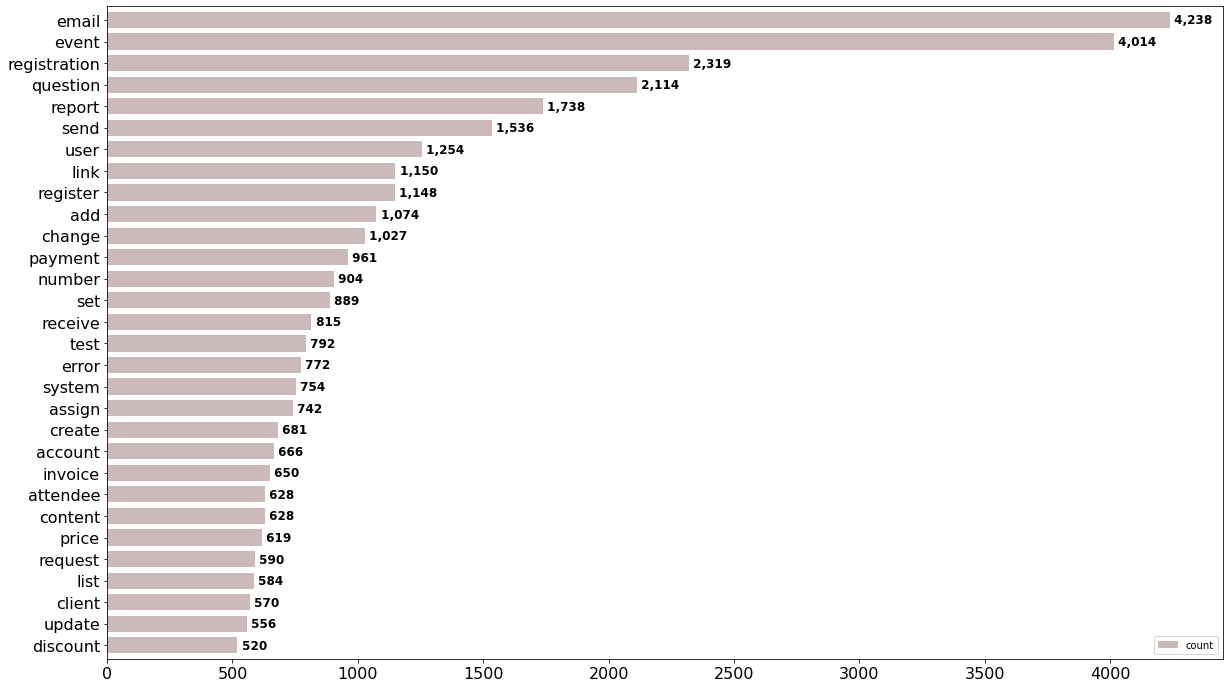

In [36]:
# plot horizontal bar graph
ax = dataframe.head(30).sort_values(by='count').plot(kind='barh', 
                                                     figsize=(20,12), 
                                                     x='words', 
                                                     y='count', 
                                                     color="#ccbaba",
                                                     fontsize=16, 
                                                     xlabel="", 
                                                     width=0.75)
#annotate pandas plot bars
for patch in ax.patches:
    ax.text(patch.get_width() + 0.3, 
            patch.get_y() + 0.2,
            " {:,}".format(patch.get_width()), 
            fontsize=12, 
            fontweight='bold')

In [37]:
#change figure background color and save
fig = ax.get_figure()
fig.patch.set_facecolor('#FFFFFF')
fig.savefig("v1_lockdown_top_30_unigram.png", facecolor=fig.get_facecolor())

# <font color='#31708f'><center>Bigram WordCloud<a class="anchor" id="third-bullet"></a></center></font>

In [28]:
NewList=[]
for words in data_lemmatized:
    NewList.append(words.replace(" ", "_"))
NewList[:6]

['possible_set_single_event_different_bookable_item_charge_different_currency_ticket_assign_thank_inquiry_here_step_outline_how_activate_multiple_currency_selection_go_setup_finance_setting_select_allow_currency_selection_click_save_result_basket_page_delegate_will_able_select_different_currency_pay_let_know_work_question_arise_kind_regard_svetlana_support_support_support_web_far_previous_email_can_create_different_general_price_bookable_item_setup_finance_price_when_set_general_price_dropdown_currency_can_select_preferred_currency_set_price_bookable_item_go_setup_finance_price_click_add_add_price_price_descriptor_name_enter_name_price_apply_select_general_price_add_new_price_enter_amount_currency_dropdown_select_preferred_currency_date_enter_when_start_line_item_description_enter_line_how_should_appear_basket_checkout_page_click_save_bookable_item_general_price_link_price_bookable_item_would_recommend_make_test_registration_see_action_basket_page_let_know_work_question_arise_kind_rega

In [25]:
NewString=''.join(NewList)

In [29]:
#stopwords = set(STOPWORDS)
from wordcloud import WordCloud
wordcloud = WordCloud(stopwords = custom_stopwords,
                      background_color="white",
                      width = 4000,
                      height = 2000,
                      max_words=200, 
                      min_word_length = 3, 
                      collocation_threshold = 3,   #create wordcloud of bigrams
                      random_state = 23        #get the same word cloud
                         ).generate(''.join(NewList))

    
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

KeyboardInterrupt: 

In [ ]:
# write to file
wordcloud.to_file("lockdown_word_cloud_bigram.png")

# <font color='#31708f'><center>Dataframe from Bigram WordCloud<a class="anchor" id="third-bullet"></a></center></font>

In [52]:
result = ''.join(data_lemmatized)
result

'possible set single event different bookable item charge different currency ticket assign thank inquiry here step outline how activate multiple currency selection go setup finance setting select allow currency selection click save result basket page delegate will able select different currency pay let know work question arise kind regard svetlana support support support web far previous email can create different general price bookable item setup finance price when set general price dropdown currency can select preferred currency set price bookable item go setup finance price click add add price price descriptor name enter name price apply select general price add new price enter amount currency dropdown select preferred currency date enter when start line item description enter line how should appear basket checkout page click save bookable item general price link price bookable item would recommend make test registration see action basket page let know work question arise kind regar

In [53]:
#remove stopwords from string
words_list = result.split()
custom_stopwords = list(STOPWORDS)+["a","about","above","after","again","against","ain","all","am","an","and","any","are","aren","aren't","as","at","be","because","been","before","being","below","between","both","but","by","can","couldn","couldn't","d","did","didn","didn't","do","does","doesn","doesn't","doing","don","don't","down","during","each","few","for","from","further","had","hadn","hadn't","has","hasn","hasn't","have","haven","haven't","having","he","her","here","hers","herself","him","himself","his","how","i","if","in","into","is","isn","isn't","it","it's","its","itself","just","ll","m","ma","me","mightn","mightn't","more","most","mustn","mustn't","my","myself","needn","needn't","no","nor","not","now","o","of","off","on","once","only","or","other","our","ours","ourselves","out","over","own","re","s","same","shan","shan't","she","she's","should","should've","shouldn","shouldn't","so","some","such","t","than","that","that'll","the","their","theirs","them","themselves","then","there","these","they","this","those","through","to","too","under","until","up","ve","very","was","wasn","wasn't","we","were","weren","weren't","what","when","where","which","while","who","whom","why","will","with","won","won't","wouldn","wouldn't","y","you","you'd","you'll","you're","you've","your","yours","yourself","yourselves","could","he'd","he'll","he's","here's","how's","i'd","i'll","i'm","i've","let's","ought","she'd","she'll","that's","there's","they'd","they'll","they're","they've","we'd","we'll","we're","we've","what's","when's","where's","who's","why's","would","able","abst","accordance","according","accordingly","across","act","actually","added","adj","affected","affecting","affects","afterwards","ah","almost","alone","along","already","also","although","always","among","amongst","announce","another","anybody","anyhow","anymore","anyone","anything","anyway","anyways","anywhere","apparently","approximately","arent","arise","around","aside","ask","asking","auth","available","away","awfully","b","back","became","become","becomes","becoming","beforehand","begin","beginning","beginnings","begins","behind","believe","beside","besides","beyond","biol","brief","briefly","c","ca","came","cannot","can't","cause","causes","certain","certainly","co","com","come","comes","contain","containing","contains","couldnt","date","different","done","downwards","due","e","ed","edu","effect","eg","eight","eighty","either","else","elsewhere","end","ending","enough","especially","et","etc","even","ever","every","everybody","everyone","everything","everywhere","ex","except","f","far","ff","fifth","first","five","fix","followed","following","follows","former","formerly","forth","found","four","furthermore","g","gave","get","gets","getting","give","given","gives","giving","go","goes","gone","got","gotten","h","happens","hardly","hed","hence","hereafter","hereby","herein","heres","hereupon","hes","hi","hid","hither","home","howbeit","however","hundred","id","ie","im","immediate","immediately","importance","important","inc","indeed","index","information","instead","invention","inward","itd","it'll","j","k","keep","keeps","kept","kg","km","know","known","knows","l","largely","last","lately","later","latter","latterly","least","less","lest","let","lets","like","liked","likely","line","little","'ll","look","looking","looks","ltd","made","mainly","make","makes","many","may","maybe","mean","means","meantime","meanwhile","merely","mg","might","million","miss","ml","moreover","mostly","mr","mrs","much","mug","must","n","na","name","namely","nay","nd","near","nearly","necessarily","necessary","need","needs","neither","never","nevertheless","new","next","nine","ninety","nobody","non","none","nonetheless","noone","normally","nos","noted","nothing","nowhere","obtain","obtained","obviously","often","oh","ok","okay","old","omitted","one","ones","onto","ord","others","otherwise","outside","overall","owing","p","page","pages","part","particular","particularly","past","per","perhaps","placed","please","plus","poorly","possible","possibly","potentially","pp","predominantly","present","previously","primarily","probably","promptly","proud","provides","put","q","que","quickly","quite","qv","r","ran","rather","rd","readily","really","recent","recently","ref","refs","regarding","regardless","regards","related","relatively","research","respectively","resulted","resulting","results","right","run","said","saw","say","saying","says","sec","section","see","seeing","seem","seemed","seeming","seems","seen","self","selves","sent","seven","several","shall","shed","shes","show","showed","shown","showns","shows","significant","significantly","similar","similarly","since","six","slightly","somebody","somehow","someone","somethan","something","sometime","sometimes","somewhat","somewhere","soon","sorry","specifically","specified","specify","specifying","still","stop","strongly","sub","substantially","successfully","sufficiently","suggest","sup","sure","take","taken","taking","tell","tends","th","thank","thanks","thanx","thats","that've","thence","thereafter","thereby","thered","therefore","therein","there'll","thereof","therere","theres","thereto","thereupon","there've","theyd","theyre","think","thou","though","thoughh","thousand","throug","throughout","thru","thus","til","tip","together","took","toward","towards","tried","tries","truly","try","trying","ts","twice","two","u","un","unfortunately","unless","unlike","unlikely","unto","upon","ups","us","use","used","useful","usefully","usefulness","uses","using","usually","v","value","various","'ve","via","viz","vol","vols","vs","w","want","wants","wasnt","way","wed","welcome","went","werent","whatever","what'll","whats","whence","whenever","whereafter","whereas","whereby","wherein","wheres","whereupon","wherever","whether","whim","whither","whod","whoever","whole","who'll","whomever","whos","whose","widely","willing","wish","within","without","wont","words","world","wouldnt","www","x","yes","yet","youd","youre","z","zero","a's","ain't","allow","allows","apart","appear","appreciate","appropriate","associated","best","better","c'mon","c's","cant","changes","clearly","concerning","consequently","consider","considering","corresponding","course","currently","definitely","described","despite","entirely","exactly","example","going","greetings","hello","help","hopefully","ignored","inasmuch","indicate","indicated","indicates","inner","insofar","it'd","keep","keeps","novel","presumably","reasonably","second","secondly","sensible","serious","seriously","sure","t's","third","thorough","thoroughly","three","well","wonder", "regard", "kind", "technical", "ticket", "message", "team", "click", "day", "work", "close", "issue", "check", "pivotal", "confidential", "tracker", "attachment", "copy", "time", "follow", "free", "round", "select", "good", "detail", "recipient", "virus", "datum", "notify", "intend", "sender", "delegate", "story", "leader", "address", "assistance", "feel", "accept", "step", "option", "find", "reply", "call", "item", "reopen", "provide", "office", "respond", "note", "happen", "setup", "lovely", "save", "confirm", "advise", "disclose", "addressee", "hope", "development", "business", "privileged", "comment", "great", "entry", "solely", "display", "answer", "company", "intended", "expect", "include", "inquiry", "problem", "start", "case", "remove", "open", "base", "card", "icon", "subject", "response", "hear", "liability", "head", "chat", "text", "correct", "morning", "button", "write", "reach", "medium", "alternative", "share", "limit", "pull", "url", "malware", "damage", "purpose", "touch", "screenshot", "audit", "article", "colleague", "notice", "action", "bookable", "customer", "investigate", "tutorial", "finance", "attach", "understand", "store", "query", "loss", "speak", "external", "result", "responsibility", "forward", "trail", "discuss", "solution", "place", "state", "apply", "experience", "mention", "reason", "raise", "additional", "today", "visit", "conference", "submit", "outline", "distribute", "direct", "print", "legally", "screen", "bug", "monitor", "fine", "tttttttt", "read", "minute", "management", "full", "year", "operator", "replicate", "transaction", "administrator", "individual", "recommend", "backend", "method", "twitter", "point", "agenda", "database", "transmit", "exist", "afraid", "carry", "virtual", "proprietary", "prohibit", "dependent", "confirmation", "resolve", "connect", "exam", "quick", "correctly", "unable", "student", "marketing", "mark", "credit", "security", "garry", "deliver", "notification", "british", "assist", "easy", "ill", "retain", "relation", "original", "helpful", "testing", "future", "platform", "browser", "amp", "thing", "week", "attempt", "long", "network", "amendment", "active", "specific", "opportunity", "staff", "happy", "moment", "strictly", "apology", "instance", "hour", "form", "sort", "cultural", "educational", "previous", "requirement", "authorise", "continue", "return", "bottom", "confidentiality", "council", "dropdown", "leave", "environment", "tomorrow", "phone", "clear", "lot", "fail", "bot", "online", "charge", "muir", "gayle", "box", "coordinator", "vinay", "proceed", "behalf", "separate", "replication", "description", "tool", "menu", "visible", "early", "info", "safe", "software", "mandatory", "certificate", "developer", "calendar", "move", "schroder", "design", "entire", "manually", "current", "function", "caution", "general", "checkbox", "opinion", "blank", "reserve", "delivery", "refund", "society", "automatically", "talk", "supplementary", "explain", "clarify", "idea", "relate", "blog", "disclosure", "selection", "turn ", "default", "represent", "nice", "cancellation", "block", "policy", "college", "shortly", "copying", "bit", "practice", "senior", "wait", "submitter", "directly", "lawful", "claire", "computer", "purchase", "wenlock", "guarantee", "period", "market", "express", "profile", "usual", "warrant", "disclaimer", "aware", "deactivate", "wrong", "reliance", "product", "sandbox", "switch", "subsidiary", "month", "weekend", "fee", "country", "sophie", "fire", "charity", "statement", "virusfree", "registered", "functionality", "common", "tarla", "tttt", "currency", "choose", "floor", "title", "provider", "government", "private", "hesitate", "adjust", "saml", "outstanding", "pencil", "svetlana", "panel", "delay", "attention", "regulation", "chemistry", "instruction", "member", "scenario", "dev", "originate", "advice", "afternoon", "release", "side", "road", "equal", "trigger", "technology", "wale", "pick", "webinar", "royal", "affect", "merge", "format", "term", "guide", "peaceful", "redirect", "solve", "money", "hold", "transmission", "invite", "emma", "distribution", "incomplete", "chrome", "organisation", "property", "working", "cost", "emily", "expire", "school", "sense", "tick", "preview", "assume", "copyright", "glad", "special", "news", "asap", "material", "join", "prevent", "application", "electronic", "ahead", "large", "receipt", "history", "feedback", "restrict", "trust", "post", "double", "highlight", "relevant", "successful", "frontend", "area", "cookie", "evening", "simply", "enable", "yesterday", "sound", "cheer", "valente", "archive", "winner", "telephone", "invitee", "reminder", "failure", "transfer", "host", "staging", "anshu", "situation", "offer", "couple", "contract", "tatiana", "booker", "pricing", "eileen", "unauthorised", "faculty", "art", "legal", "global", "corner", "exclude", "destroy", "employee", "green", "standard", "basis", "ellie", "consequence", "workaround", "character", "entity", "law", "officer", "centre", "engage", "extract", "chance", "regulate", "bulk", "cover", "endeavour", "tech", "adrian", "finish", "annual", "decide", "condition", "exceptional", "sabine", "poster", "quantity", "inform", "invalid", "prompt", "remember", "executive", "unlawful", "hover", "maguire", "firstname", "lock", "privilege", "markedasprinte", "eventforce", "tania", "incorrect", "haymarket", "mind", "header", "lastname", "organiser", "locate", "ielt", "melissa", "internal", "switchboard", "adhoc", "risk", "planner", "determine", "candidate", "normal", "origin", "unpaid", "anthony", "avoid ", "operational", "venue", "knowledge", "identify", "row", "handle", "extend", "fre", "footer", "band", "sharma", "jpg", "party", "intercept", "valid", "ebook", "sector", "worry", "occur", "TRUE", "professional", "investigation", "actuary", "internet", "connection", "regulatory", "widget", "reasonable", "achieve", "typically", "properly", "encounter", "scroll", "small", "exact", "dynamic", "success", "spam", "recognise", "exclusive", "lose", "window", "convert", "remotely", "crash", "unsubmitted", "straight", "dear", "expert", "impact", "investment", "precaution", "iop", "remain", "collect", "matter", "mode", "clarification", "level", "filipa", "trevor", "fisher", "manager", "support", "apac", "web", "eventsforce"]
words_without_stopwords = [word for word in words_list if word not in custom_stopwords]

In [51]:
#find n-grams
import nltk
from collections import Counter
from nltk import ngrams

#remove stopwords from string
words_list = result.split()
custom_stopwords = list(STOPWORDS)+["a","about","above","after","again","against","ain","all","am","an","and","any","are","aren","aren't","as","at","be","because","been","before","being","below","between","both","but","by","can","couldn","couldn't","d","did","didn","didn't","do","does","doesn","doesn't","doing","don","don't","down","during","each","few","for","from","further","had","hadn","hadn't","has","hasn","hasn't","have","haven","haven't","having","he","her","here","hers","herself","him","himself","his","how","i","if","in","into","is","isn","isn't","it","it's","its","itself","just","ll","m","ma","me","mightn","mightn't","more","most","mustn","mustn't","my","myself","needn","needn't","no","nor","not","now","o","of","off","on","once","only","or","other","our","ours","ourselves","out","over","own","re","s","same","shan","shan't","she","she's","should","should've","shouldn","shouldn't","so","some","such","t","than","that","that'll","the","their","theirs","them","themselves","then","there","these","they","this","those","through","to","too","under","until","up","ve","very","was","wasn","wasn't","we","were","weren","weren't","what","when","where","which","while","who","whom","why","will","with","won","won't","wouldn","wouldn't","y","you","you'd","you'll","you're","you've","your","yours","yourself","yourselves","could","he'd","he'll","he's","here's","how's","i'd","i'll","i'm","i've","let's","ought","she'd","she'll","that's","there's","they'd","they'll","they're","they've","we'd","we'll","we're","we've","what's","when's","where's","who's","why's","would","able","abst","accordance","according","accordingly","across","act","actually","added","adj","affected","affecting","affects","afterwards","ah","almost","alone","along","already","also","although","always","among","amongst","announce","another","anybody","anyhow","anymore","anyone","anything","anyway","anyways","anywhere","apparently","approximately","arent","arise","around","aside","ask","asking","auth","available","away","awfully","b","back","became","become","becomes","becoming","beforehand","begin","beginning","beginnings","begins","behind","believe","beside","besides","beyond","biol","brief","briefly","c","ca","came","cannot","can't","cause","causes","certain","certainly","co","com","come","comes","contain","containing","contains","couldnt","date","different","done","downwards","due","e","ed","edu","effect","eg","eight","eighty","either","else","elsewhere","end","ending","enough","especially","et","etc","even","ever","every","everybody","everyone","everything","everywhere","ex","except","f","far","ff","fifth","first","five","fix","followed","following","follows","former","formerly","forth","found","four","furthermore","g","gave","get","gets","getting","give","given","gives","giving","go","goes","gone","got","gotten","h","happens","hardly","hed","hence","hereafter","hereby","herein","heres","hereupon","hes","hi","hid","hither","home","howbeit","however","hundred","id","ie","im","immediate","immediately","importance","important","inc","indeed","index","information","instead","invention","inward","itd","it'll","j","k","keep","keeps","kept","kg","km","know","known","knows","l","largely","last","lately","later","latter","latterly","least","less","lest","let","lets","like","liked","likely","line","little","'ll","look","looking","looks","ltd","made","mainly","make","makes","many","may","maybe","mean","means","meantime","meanwhile","merely","mg","might","million","miss","ml","moreover","mostly","mr","mrs","much","mug","must","n","na","name","namely","nay","nd","near","nearly","necessarily","necessary","need","needs","neither","never","nevertheless","new","next","nine","ninety","nobody","non","none","nonetheless","noone","normally","nos","noted","nothing","nowhere","obtain","obtained","obviously","often","oh","ok","okay","old","omitted","one","ones","onto","ord","others","otherwise","outside","overall","owing","p","page","pages","part","particular","particularly","past","per","perhaps","placed","please","plus","poorly","possible","possibly","potentially","pp","predominantly","present","previously","primarily","probably","promptly","proud","provides","put","q","que","quickly","quite","qv","r","ran","rather","rd","readily","really","recent","recently","ref","refs","regarding","regardless","regards","related","relatively","research","respectively","resulted","resulting","results","right","run","said","saw","say","saying","says","sec","section","see","seeing","seem","seemed","seeming","seems","seen","self","selves","sent","seven","several","shall","shed","shes","show","showed","shown","showns","shows","significant","significantly","similar","similarly","since","six","slightly","somebody","somehow","someone","somethan","something","sometime","sometimes","somewhat","somewhere","soon","sorry","specifically","specified","specify","specifying","still","stop","strongly","sub","substantially","successfully","sufficiently","suggest","sup","sure","take","taken","taking","tell","tends","th","thank","thanks","thanx","thats","that've","thence","thereafter","thereby","thered","therefore","therein","there'll","thereof","therere","theres","thereto","thereupon","there've","theyd","theyre","think","thou","though","thoughh","thousand","throug","throughout","thru","thus","til","tip","together","took","toward","towards","tried","tries","truly","try","trying","ts","twice","two","u","un","unfortunately","unless","unlike","unlikely","unto","upon","ups","us","use","used","useful","usefully","usefulness","uses","using","usually","v","value","various","'ve","via","viz","vol","vols","vs","w","want","wants","wasnt","way","wed","welcome","went","werent","whatever","what'll","whats","whence","whenever","whereafter","whereas","whereby","wherein","wheres","whereupon","wherever","whether","whim","whither","whod","whoever","whole","who'll","whomever","whos","whose","widely","willing","wish","within","without","wont","words","world","wouldnt","www","x","yes","yet","youd","youre","z","zero","a's","ain't","allow","allows","apart","appear","appreciate","appropriate","associated","best","better","c'mon","c's","cant","changes","clearly","concerning","consequently","consider","considering","corresponding","course","currently","definitely","described","despite","entirely","exactly","example","going","greetings","hello","help","hopefully","ignored","inasmuch","indicate","indicated","indicates","inner","insofar","it'd","keep","keeps","novel","presumably","reasonably","second","secondly","sensible","serious","seriously","sure","t's","third","thorough","thoroughly","three","well","wonder", "regard", "kind", "technical", "ticket", "message", "team", "click", "day", "work", "close", "issue", "check", "pivotal", "confidential", "tracker", "attachment", "copy", "time", "follow", "free", "round", "select", "good", "detail", "recipient", "virus", "datum", "notify", "intend", "sender", "delegate", "story", "leader", "address", "assistance", "feel", "accept", "step", "option", "find", "reply", "call", "item", "reopen", "provide", "office", "respond", "note", "happen", "setup", "lovely", "save", "confirm", "advise", "disclose", "addressee", "hope", "development", "business", "privileged", "comment", "great", "entry", "solely", "display", "answer", "company", "intended", "expect", "include", "inquiry", "problem", "start", "case", "remove", "open", "base", "card", "icon", "subject", "response", "hear", "liability", "head", "chat", "text", "correct", "morning", "button", "write", "reach", "medium", "alternative", "share", "limit", "pull", "url", "malware", "damage", "purpose", "touch", "screenshot", "audit", "article", "colleague", "notice", "action", "bookable", "customer", "investigate", "tutorial", "finance", "attach", "understand", "store", "query", "loss", "speak", "external", "result", "responsibility", "forward", "trail", "discuss", "solution", "place", "state", "apply", "experience", "mention", "reason", "raise", "additional", "today", "visit", "conference", "submit", "outline", "distribute", "direct", "print", "legally", "screen", "bug", "monitor", "fine", "tttttttt", "read", "minute", "management", "full", "year", "operator", "replicate", "transaction", "administrator", "individual", "recommend", "backend", "method", "twitter", "point", "agenda", "database", "transmit", "exist", "afraid", "carry", "virtual", "proprietary", "prohibit", "dependent", "confirmation", "resolve", "connect", "exam", "quick", "correctly", "unable", "student", "marketing", "mark", "credit", "security", "garry", "deliver", "notification", "british", "assist", "easy", "ill", "retain", "relation", "original", "helpful", "testing", "future", "platform", "browser", "amp", "thing", "week", "attempt", "long", "network", "amendment", "active", "specific", "opportunity", "staff", "happy", "moment", "strictly", "apology", "instance", "hour", "form", "sort", "cultural", "educational", "previous", "requirement", "authorise", "continue", "return", "bottom", "confidentiality", "council", "dropdown", "leave", "environment", "tomorrow", "phone", "clear", "lot", "fail", "bot", "online", "charge", "muir", "gayle", "box", "coordinator", "vinay", "proceed", "behalf", "separate", "replication", "description", "tool", "menu", "visible", "early", "info", "safe", "software", "mandatory", "certificate", "developer", "calendar", "move", "schroder", "design", "entire", "manually", "current", "function", "caution", "general", "checkbox", "opinion", "blank", "reserve", "delivery", "refund", "society", "automatically", "talk", "supplementary", "explain", "clarify", "idea", "relate", "blog", "disclosure", "selection", "turn ", "default", "represent", "nice", "cancellation", "block", "policy", "college", "shortly", "copying", "bit", "practice", "senior", "wait", "submitter", "directly", "lawful", "claire", "computer", "purchase", "wenlock", "guarantee", "period", "market", "express", "profile", "usual", "warrant", "disclaimer", "aware", "deactivate", "wrong", "reliance", "product", "sandbox", "switch", "subsidiary", "month", "weekend", "fee", "country", "sophie", "fire", "charity", "statement", "virusfree", "registered", "functionality", "common", "tarla", "tttt", "currency", "choose", "floor", "title", "provider", "government", "private", "hesitate", "adjust", "saml", "outstanding", "pencil", "svetlana", "panel", "delay", "attention", "regulation", "chemistry", "instruction", "member", "scenario", "dev", "originate", "advice", "afternoon", "release", "side", "road", "equal", "trigger", "technology", "wale", "pick", "webinar", "royal", "affect", "merge", "format", "term", "guide", "peaceful", "redirect", "solve", "money", "hold", "transmission", "invite", "emma", "distribution", "incomplete", "chrome", "organisation", "property", "working", "cost", "emily", "expire", "school", "sense", "tick", "preview", "assume", "copyright", "glad", "special", "news", "asap", "material", "join", "prevent", "application", "electronic", "ahead", "large", "receipt", "history", "feedback", "restrict", "trust", "post", "double", "highlight", "relevant", "successful", "frontend", "area", "cookie", "evening", "simply", "enable", "yesterday", "sound", "cheer", "valente", "archive", "winner", "telephone", "invitee", "reminder", "failure", "transfer", "host", "staging", "anshu", "situation", "offer", "couple", "contract", "tatiana", "booker", "pricing", "eileen", "unauthorised", "faculty", "art", "legal", "global", "corner", "exclude", "destroy", "employee", "green", "standard", "basis", "ellie", "consequence", "workaround", "character", "entity", "law", "officer", "centre", "engage", "extract", "chance", "regulate", "bulk", "cover", "endeavour", "tech", "adrian", "finish", "annual", "decide", "condition", "exceptional", "sabine", "poster", "quantity", "inform", "invalid", "prompt", "remember", "executive", "unlawful", "hover", "maguire", "firstname", "lock", "privilege", "markedasprinte", "eventforce", "tania", "incorrect", "haymarket", "mind", "header", "lastname", "organiser", "locate", "ielt", "melissa", "internal", "switchboard", "adhoc", "risk", "planner", "determine", "candidate", "normal", "origin", "unpaid", "anthony", "avoid ", "operational", "venue", "knowledge", "identify", "row", "handle", "extend", "fre", "footer", "band", "sharma", "jpg", "party", "intercept", "valid", "ebook", "sector", "worry", "occur", "TRUE", "professional", "investigation", "actuary", "internet", "connection", "regulatory", "widget", "reasonable", "achieve", "typically", "properly", "encounter", "scroll", "small", "exact", "dynamic", "success", "spam", "recognise", "exclusive", "lose", "window", "convert", "remotely", "crash", "unsubmitted", "straight", "dear", "expert", "impact", "investment", "precaution", "iop", "remain", "collect", "matter", "mode", "clarification", "level", "filipa", "trevor", "fisher", "manager", "support", "apac", "web", "eventsforce"]
words_without_stopwords = [word for word in words_list if word not in custom_stopwords]

ngram_counts = Counter(ngrams(words_without_stopwords,2)) 
ngram_counts.most_common(30)

[(('email', 'email'), 454),
 (('event', 'event'), 348),
 (('email', 'send'), 294),
 (('send', 'email'), 252),
 (('receive', 'email'), 239),
 (('question', 'question'), 235),
 (('report', 'report'), 234),
 (('content', 'email'), 206),
 (('receive', 'error'), 195),
 (('question', 'request'), 189),
 (('email', 'content'), 173),
 (('view', 'add'), 171),
 (('registration', 'question'), 160),
 (('error', 'delete'), 157),
 (('email', 'error'), 155),
 (('event', 'registration'), 151),
 (('registration', 'number'), 146),
 (('registration', 'event'), 144),
 (('email', 'receive'), 141),
 (('link', 'email'), 135),
 (('attendee', 'category'), 135),
 (('content', 'person'), 129),
 (('registration', 'contact'), 128),
 (('payment', 'status'), 127),
 (('registration', 'registration'), 122),
 (('change', 'view'), 122),
 (('event', 'email'), 118),
 (('email', 'register'), 118),
 (('event', 'number'), 118),
 (('register', 'number'), 113)]

In [41]:
df = pd.DataFrame.from_dict(ngram_counts, orient='index').reset_index()
df.columns =['words', 'count']

#sort pandas dataframe
df.sort_values(by=['count'], inplace=True, ascending=False)
#join string
df["words"]= df["words"].str.join("_")
df[:30]

,words,count
609,email_email,454
525,event_event,348
701,email_send,294
87,send_email,252
811,receive_email,239
37,question_question,235
378,report_report,234
1219,content_email,206
77,receive_error,195
38,question_request,189


(Optional)

In [ ]:
#convert pandas dataframe to list
bigram_list_all = df.words.tolist()
bigram_list = bigram_list_all[:200]
bigram_list

# <font color='#31708f'><center>Top 30 Bigrams in Zendesk Tickets<a class="anchor" id="third-bullet"></a></center></font>

In [ ]:
# plot horizontal bar graph
ax = df.head(30).sort_values(by='count').plot(kind='barh', 
                                                     figsize=(20,12), 
                                                     x='words', 
                                                     y='count', 
                                                     color="#ccbaba",
                                                     fontsize=16, 
                                                     xlabel="", 
                                                     width=0.75)
#annotate pandas plot bars
for patch in ax.patches:
    ax.text(patch.get_width() + 0.3, 
            patch.get_y() + 0.2,
            " {:,}".format(patch.get_width()), 
            fontsize=12, 
            fontweight='bold')

In [ ]:
#change figure background color and save
fig = ax.get_figure()
fig.patch.set_facecolor('#FFFFFF')
fig.savefig("lockdown_top_30_bigram.png", facecolor=fig.get_facecolor())

# <font color='#31708f'><center>CountVectorizer<a class="anchor" id="fourth-bullet"></a></center></font>

# <font color='#576675'>Create the Document-Word matrix</font>

In [ ]:
#Convert a collection of text documents to a matrix of token counts
vectorizer=CountVectorizer(analyzer='word',   
                           token_pattern='[a-zA-Z]{3,}', # only non-digit characters > 3
                           stop_words=custom_stopwords,  # remove stop words
                           lowercase=True,               # convert all words to lowercase
                           # min_df=10,                  # minimum reqd occurences of a word
                           # max_features=50000,         # max number of uniq words
                           
                       )
    
# this step generates word counts for the words in your docs 
data_vectorized=vectorizer.fit_transform(data_lemmatized)

6 rows (6 tickets), 54 columns (unique words)

In [ ]:
#check rows(docs) and columns(unique words), minus single character words
#The columns number is raw word frequency
data_vectorized.shape

In [ ]:
(Optional)

In [ ]:
print(vectorizer.get_feature_names())

In [ ]:
(Optional)

How many times a word has been used in a ticket

In [ ]:
print(data_vectorized.toarray())

# <font color='#576675'>Count</font>

Get top_n_words:

In [ ]:
#Count column in Excel spreadsheet
np.asarray(data_vectorized.sum(axis=0))

In [ ]:
sum_words = np.asarray(data_vectorized.sum(axis=0))

In [ ]:
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
sorted_words_freq =sorted(words_freq, 
                          key = lambda x: x[1], 
                          reverse=True)
sorted_words_freq[:10]

In [ ]:
dataframe = pd.DataFrame(sorted_words_freq[:200],
                         columns=['words', 'count'])


dataframe.head(201)

dataframe.style.set_properties(subset=['words', 'count'], **{'width': '200px'})

In [ ]:
# select rows in pandas dataframe
sliced = dataframe.iloc[[1,2,5,7,9,10,16,18,19,20,21,22,24,25,26,31,32,33,34,40,43,44,45,46,48,53,54,57,61,62,64,68,70,71,72,77,85,86,92,102,106,108,109,112,124,126,138,140,141,144,147,149,150,152,154,157,158,163,164,167,168,170,176,196,198], [0,1]]

sliced.style.set_properties(subset=['words', 'count'], **{'width': '200px'})

In [ ]:
#create horizontal barplot
ax = sliced.head(10).plot.barh(x='words', y='count')